In [10]:
import numpy as np
from omnisafe.models.actor import GaussianLearningActor
import safety_gymnasium
import torch
from load_model import load_guide
from tqdm import tqdm
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# Generating a dataset

In [ ]:
env = safety_gymnasium.make('SafetyPointGoal1-v0', max_episode_steps=1000)

def create_random_agent(env, hidden_layers=[255,255,255,255], activation='relu', weight_initialization_mode='orthogonal'):
    obs_space = env.observation_space
    act_space = env.action_space
    return GaussianLearningActor(obs_space, act_space, hidden_layers, activation=activation, weight_initialization_mode=weight_initialization_mode)

In [3]:
env.obs_space_dict.keys()

KeysView(Dict('accelerometer': Box(-inf, inf, (3,), float64), 'velocimeter': Box(-inf, inf, (3,), float64), 'gyro': Box(-inf, inf, (3,), float64), 'magnetometer': Box(-inf, inf, (3,), float64), 'goal_lidar': Box(0.0, 1.0, (16,), float64), 'hazards_lidar': Box(0.0, 1.0, (16,), float64), 'vases_lidar': Box(0.0, 1.0, (16,), float64)))

In [4]:
env.action_space

Box(-1.0, 1.0, (2,), float64)

In [ ]:
def run_trajectory(env, agent, safe_agent, min_rand_steps=100, max_rand_steps=400, cost_window=200, deterministic=True):
    observation, info = env.reset()
    episode_over = False
    is_sampling = False
    sampled_cost = 0
    sampling_step = 0
    agent_instance_for_pos = env.unwrapped.__getattribute__("task").agent
    data = []
    labels = []
    # get a random number for the amount of steps the random agent should take before a sample is created
    num_steps = np.random.randint(min_rand_steps, max_rand_steps)
    # gather data
    for i in range(num_steps):
        # Discard trajectory if the agent moves out of the checkered 7x7 space, coordinates were tested manually
        if abs(agent_instance_for_pos.pos[0]) >= 3.5 or abs(agent_instance_for_pos.pos[1]) >= 3.5: 
            break
        obs_tensor = torch.from_numpy(observation).float()
        action = agent.predict(obs_tensor, deterministic=deterministic).detach().numpy()
        if i == num_steps - 1:
            data.append(np.append(observation, action)) 
        observation, reward, cost, terminated, truncated, info = env.step(action)
        episode_over = terminated or truncated
        if episode_over:
            break
    if not episode_over:
        # sample with the pre trained agent
        for i in range(cost_window):
            obs_tensor = torch.from_numpy(observation).float()
            action = safe_agent.predict(obs_tensor, deterministic=deterministic).detach().numpy()
            observation, reward, cost, terminated, truncated, info = env.step(action)
            episode_over = terminated or truncated
            sampled_cost += cost
            sampling_step += 1
            if episode_over or i == cost_window - 1:
                labels.append(sampled_cost)
                break
    if len(labels) == 0:
        # If episode ended before sampling could happen, return an empty data and labels array
        # More of a safety measure, probably obsolete
        data = []
    if len(data) == 0:
        labels = []
    env.close()
    # assertion to make sure every data point has a label
    assert len(data) == len(labels)
    return np.array(data), np.array(labels)

In [37]:
# load my saved trained agent
safe_agent = load_guide("../runs/PPOLag-{SafetyPointGoal1-v0}/seed-000-2025-05-13-17-51-08", "epoch-50.pt")[1]

/tmp/ipykernel_968/1383116929.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(model_path)


In [38]:
data, labels = run_trajectory(env, create_random_agent(env), safe_agent)
labels.shape

(1,)

In [39]:
print(labels)

[0.]


In [40]:
data.shape

(1, 62)

In [41]:
len(data)

1

In [ ]:
def generate_dataset(env, safe_agent, amount=1000):
    data = []
    labels = []
    for _ in tqdm(range(amount), desc="Generating data points", unit=" sample "):
        data_i = []
        while len(data_i) == 0: # Ensure that a sample is generated
            data_i, labels_i = run_trajectory(env, create_random_agent(env), safe_agent)
        data.append(data_i)
        labels.append(labels_i)
    return np.concatenate(data, axis=0)[:amount], np.concatenate(labels, axis=0)[:amount]

In [62]:
data, labels = generate_dataset(env, safe_agent, amount=100000)

Generating data points: 100%|██████████| 100000/100000 [34:24:11<00:00,  1.24s/ sample ]  


In [63]:
data

array([[-0.769528  , 11.532802  ,  9.81      , ...,  0.        ,
        -1.25018418,  0.04445577],
       [-1.78246786, -1.58724729,  9.81      , ...,  0.        ,
        -0.14957084,  1.56127739],
       [ 2.15435992,  1.39720127,  9.81      , ...,  0.        ,
         1.01796758,  1.85080564],
       ...,
       [-1.83884534,  3.34935218,  9.81      , ...,  0.        ,
        -0.72516757,  0.78899771],
       [-1.92601718, -1.2521395 ,  9.81      , ...,  0.        ,
        -1.02038395,  1.09551978],
       [ 2.16149193, -1.39934431,  9.81      , ...,  0.        ,
         0.90575391, -1.78019655]])

In [64]:
data.shape

(100000, 62)

In [65]:
labels

array([ 0.,  0.,  0., ..., 46.,  0., 16.])

In [66]:
labels.shape

(100000,)

# Preprocessing the dataset for better NN performance

In [5]:
obs_column_names = ['accelerometer0', 'accelerometer1', 'accelerometer2', 'velocimeter0', 'velocimeter1', 'velocimeter2', 'gyro0', 'gyro1', 'gyro2', 'magnetometer0', 'magnetometer1', 'magnetometer2']
for key in ['goal_lidar', 'hazards_lidar', 'vases_lidar']:
    for i in range(16):
        obs_column_names.append(key+str(i))
obs_column_names.append("action0")
obs_column_names.append("action1")
len(obs_column_names)

62

In [ ]:
df = pd.DataFrame(data=data, columns=obs_column_names)
df['exp_cost'] = labels
df.head()

NameError: name 'data' is not defined

In [70]:
# save the create dataset in a pickle file
df.to_pickle("SafetyPointGoal1Dataset0.pkl")

# Validating Correctness of the Dataset and Determining Important Features

In [5]:
# load dataset from pickle file
df = pd.read_pickle("SafetyPointGoal1Dataset0.pkl")

In [6]:
df.head()

,accelerometer0,accelerometer1,accelerometer2,velocimeter0,velocimeter1,velocimeter2,gyro0,gyro1,gyro2,magnetometer0,magnetometer1,magnetometer2,goal_lidar0,goal_lidar1,goal_lidar2,goal_lidar3,goal_lidar4,goal_lidar5,goal_lidar6,goal_lidar7,goal_lidar8,goal_lidar9,goal_lidar10,goal_lidar11,goal_lidar12,goal_lidar13,goal_lidar14,goal_lidar15,hazards_lidar0,hazards_lidar1,hazards_lidar2,hazards_lidar3,hazards_lidar4,hazards_lidar5,hazards_lidar6,hazards_lidar7,hazards_lidar8,hazards_lidar9,hazards_lidar10,hazards_lidar11,hazards_lidar12,hazards_lidar13,hazards_lidar14,hazards_lidar15,vases_lidar0,vases_lidar1,vases_lidar2,vases_lidar3,vases_lidar4,vases_lidar5,vases_lidar6,vases_lidar7,vases_lidar8,vases_lidar9,vases_lidar10,vases_lidar11,vases_lidar12,vases_lidar13,vases_lidar14,vases_lidar15,action0,action1,exp_cost
0,-0.769528,11.532802,9.81,-1.098218,0.577155,0.0,0.0,-0.0,0.499018,-0.470912,0.168053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.137822,0.144294,0.006471,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.012901,0.151751,0.305451,0.267432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1.250184,0.044456,0.0
1,-1.782468,-1.587247,9.81,-0.483206,0.823411,0.0,0.0,-0.0,3.031644,-0.458862,0.198610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.792152,0.797167,0.005015,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.304140,0.679550,0.509207,0.270086,0.418813,0.430784,0.011970,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.459871,0.587877,0.128005,0.0,0.0,0.0,0.0,0.0,-0.149571,1.561277,0.0
2,2.154360,1.397201,9.81,0.470486,-0.724769,0.0,0.0,-0.0,2.972175,-0.166978,0.471294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.194801,0.311719,0.116917,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.547659,0.610956,0.548868,0.506628,0.374890,0.311188,0.011197,0.589502,0.679319,0.089817,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.196361,0.729051,0.532690,0.0,0.0,0.0,0.0,0.0,1.017968,1.850806,0.0
3,2.243852,-1.231428,9.81,0.424247,0.638764,0.0,0.0,0.0,-2.975484,0.480087,-0.139702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.188402,0.660137,0.471735,0.0,0.0,0.0,0.095364,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.080166,0.725756,0.645590,0.299514,0.375319,0.517431,0.405362,0.391885,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.622711,0.637103,0.014392,0.0,0.0,0.0,0.0,0.0,0.086816,-1.768033,0.0
4,0.146395,-11.298087,9.81,1.424790,-0.295172,0.0,0.0,0.0,-0.274193,-0.203405,-0.456756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.171323,0.655031,0.765294,0.450317,0.393927,0.143275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.199097,0.865101,0.666004,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.619345,0.140426,0.0


In [7]:
df.describe().to_csv("dataset_described.csv")

In [8]:
def evaluate_column_importance_test(feature_cols, target_col, model):
    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R^2 score:", r2_score(y_test, y_pred))
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

In [18]:
# Goal Lidars
evaluate_column_importance_test([f"goal_lidar{i}" for i in range(16)], "exp_cost", LinearRegression())

R^2 score: 0.04364996046187675
Mean Squared Error: 360.5883931033093


In [ ]:
# hazard Lidars
evaluate_column_importance_test([f"hazards_lidar{i}" for i in range(16)], "exp_cost", LinearRegression())

R^2 score: 0.17699489511669053
Mean Squared Error: 310.31115806616015


In [21]:
# vases Lidars
evaluate_column_importance_test([f"vases_lidar{i}" for i in range(16)], "exp_cost", LinearRegression())

R^2 score: 0.03463951322605807
Mean Squared Error: 363.9857503005497


In [22]:
# accelerometer 
evaluate_column_importance_test([f"accelerometer{i}" for i in range(3)], "exp_cost", LinearRegression())

R^2 score: -0.00014571018091968924
Mean Squared Error: 377.10139550731884


In [23]:
# velocimeter
evaluate_column_importance_test([f"velocimeter{i}" for i in range(3)], "exp_cost", LinearRegression())

R^2 score: 0.00035164701039558377
Mean Squared Error: 376.91386874096736


In [25]:
# gyrometer
evaluate_column_importance_test([f"gyro{i}" for i in range(3)], "exp_cost", LinearRegression())

R^2 score: -9.22453413334523e-05
Mean Squared Error: 377.08123677903234


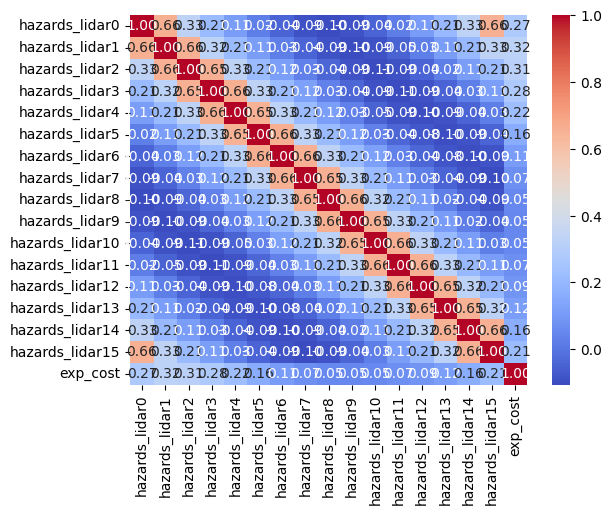

In [ ]:
hazard_cols_plus_cost = [f"hazards_lidar{i}" for i in range(16)]
hazard_cols_plus_cost.append("exp_cost")
sns.heatmap(df[hazard_cols_plus_cost].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [ ]:
from sklearn.linear_model import LassoCV

X = df.drop(columns=["exp_cost"])
y = df["exp_cost"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

print("R^2:", r2_score(y_test, lasso.predict(X_test)))

# Features being none zero can indicate that the feature is important, a negative value indicates a reverse relationship (value goes up exp_cost goes down)
important_features = pd.Series(lasso.coef_, index=X.columns)
print(important_features[important_features != 0])

Best alpha: 0.0036967689856371006
R^2: 0.1808929045101234
accelerometer0    -0.075799
accelerometer1     0.003215
velocimeter0      -0.037148
velocimeter1       0.648277
gyro2              0.096063
magnetometer0      0.020087
magnetometer1      0.532916
goal_lidar0       -1.180735
goal_lidar1       -0.734166
goal_lidar2       -3.356108
goal_lidar3       -1.866430
goal_lidar4       -2.249796
goal_lidar7        0.638013
goal_lidar9        0.944522
goal_lidar11      -1.141525
goal_lidar12      -1.219026
goal_lidar13      -0.734406
goal_lidar14      -1.354813
hazards_lidar0     5.929089
hazards_lidar1     9.580229
hazards_lidar2     7.474569
hazards_lidar3     6.294225
hazards_lidar4     5.169575
hazards_lidar5     1.984693
hazards_lidar6     1.921615
hazards_lidar7     0.063223
hazards_lidar8     1.151112
hazards_lidar9     1.250939
hazards_lidar10    2.044092
hazards_lidar11    2.013728
hazards_lidar12    1.580258
hazards_lidar13    1.545846
hazards_lidar14    3.163935
hazards_lidar15   

In [13]:
sns.set_theme(style="whitegrid")

In [39]:
def max_value_plot(features, labels, polynomial_degree=1, x_name='features', y_name='exp_cost'):
    max_features = np.max(features, axis=1)
    sns.scatterplot(x=max_features, y=labels, alpha=0.9, label="Samples")

    coeffs = np.polyfit(max_features, labels, deg=polynomial_degree)
    reg_line = np.poly1d(coeffs)
    x_line = np.linspace(max_features.min(), max_features.max(), 100)
    y_line = reg_line(x_line)
    
    sns.lineplot(x=x_line, y=y_line, color='red', label=f'Polynomial fit of degree {polynomial_degree}')
             
    plt.xlabel(f"Maximum value of {x_name}")
    plt.title(f"Max Value of {x_name} Plotted Against Expected Cost", fontsize=14, weight='bold')
    plt.ylabel("Cost")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"max_value_plot_{x_name}.png", dpi=300)
    plt.show()

In [12]:
def abs_max_value_plot(features, labels, polynomial_degree=1, x_name='features', y_name='exp_cost'):
    max_features = np.max(np.abs(features), axis=1)
    plt.scatter(max_features, labels)

    coeffs = np.polyfit(max_features, labels, deg=polynomial_degree)
    reg_line = np.poly1d(coeffs)
    x_line = np.linspace(max_features.min(), max_features.max(), 100)
    y_line = reg_line(x_line)

    plt.plot(x_line, y_line, color='red', label=f'Polynomial fit of degree {polynomial_degree}')
             
    plt.xlabel(f"Maximum value of |{x_name}|")
    plt.ylabel(y_name)
    plt.legend()
    plt.show()

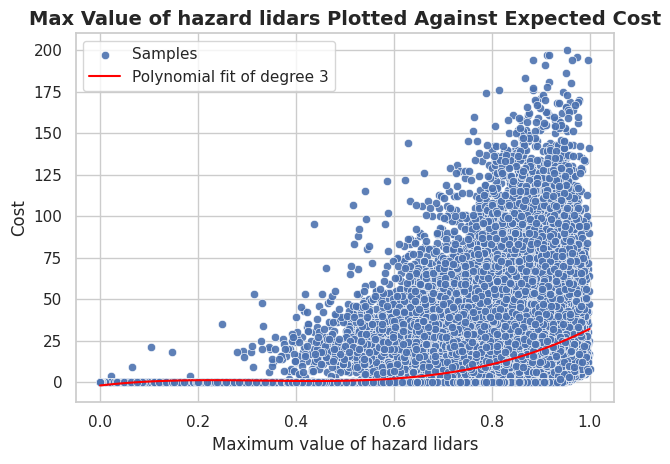

In [40]:
hazard_cols = [f"hazards_lidar{i}" for i in range(16)]
max_value_plot(df[hazard_cols], df["exp_cost"], polynomial_degree=3, x_name="hazard lidars")

The high amount of data points with a high maximum hazard lidar value and a low expected cost can probably be explain by the high maneuverability of the Point agent.
This leads to the safe policy managing to "rescue" the agent in a lot of cases even if it is close to hazards.

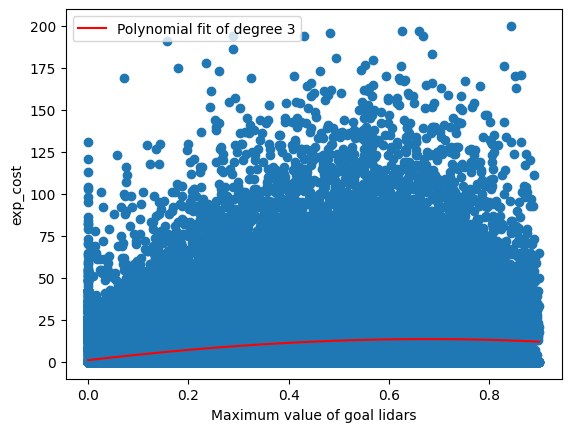

In [16]:
goal_cols = [f"goal_lidar{i}" for i in range(16)]
max_value_plot(df[goal_cols], df["exp_cost"], polynomial_degree=3, x_name="goal lidars")

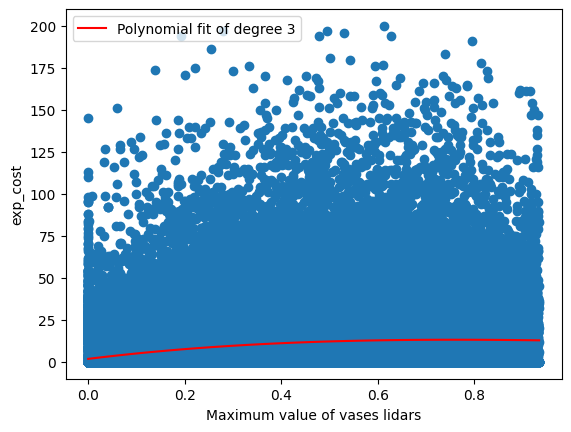

In [17]:
vases_cols = [f"vases_lidar{i}" for i in range(16)]
max_value_plot(df[vases_cols], df["exp_cost"], polynomial_degree=3, x_name="vases lidars")

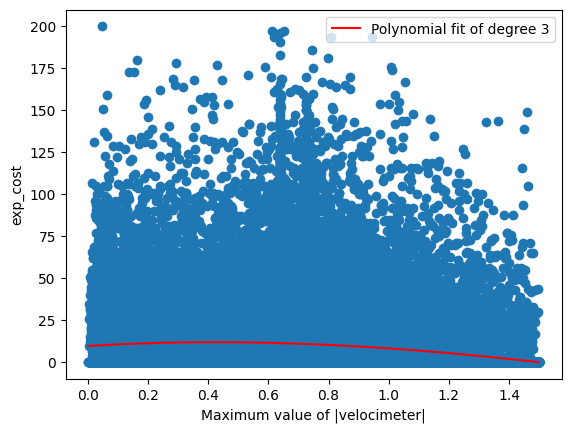

In [9]:
velo_cols = [f"velocimeter{i}" for i in range(3)]
abs_max_value_plot(df[velo_cols], df["exp_cost"], polynomial_degree=3, x_name="velocimeter")

These results suggest that the hazards lidar values are the most important features for predicting the expected cost. Goal and vases lidar values can maybe be even excluded from the data. 

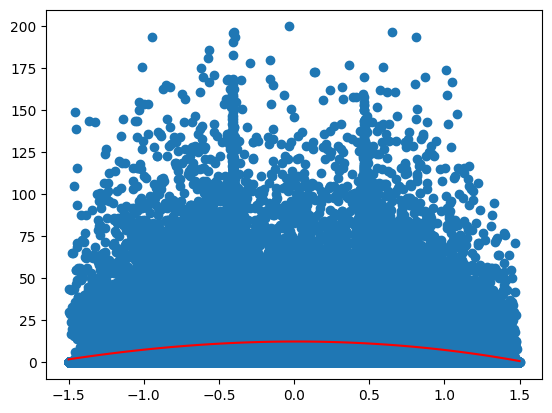

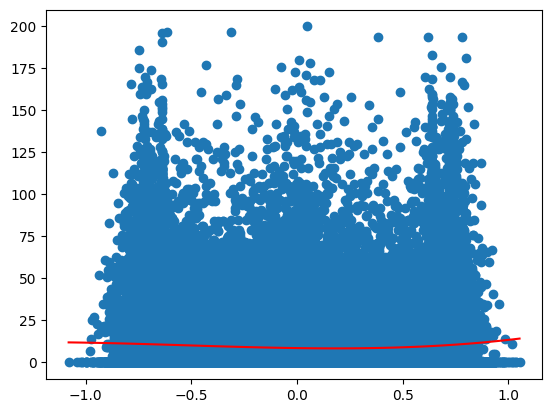

In [24]:
feature= df["velocimeter0"]
plt.scatter(feature, df["exp_cost"])

coeffs = np.polyfit(feature, df["exp_cost"], deg=3)
reg_line = np.poly1d(coeffs)
x_line = np.linspace(feature.min(), feature.max(), 100)
y_line = reg_line(x_line)

plt.plot(x_line, y_line, color='red', label=f'Polynomial fit of degree {3}')
plt.show()
feature= df["velocimeter1"]
plt.scatter(feature, df["exp_cost"])

coeffs = np.polyfit(feature, df["exp_cost"], deg=3)
reg_line = np.poly1d(coeffs)
x_line = np.linspace(feature.min(), feature.max(), 100)
y_line = reg_line(x_line)

plt.plot(x_line, y_line, color='red', label=f'Polynomial fit of degree {3}')
plt.show()

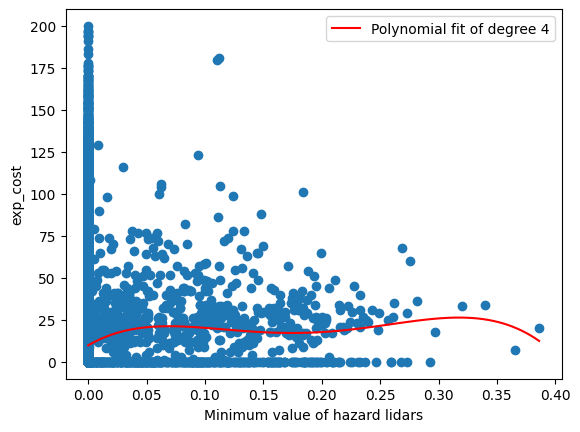

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def min_value_plot(features, labels, polynomial_degree=1, x_name='features', y_name='exp_cost'):
    min_features = np.min(features, axis=1)
    plt.scatter(min_features, labels)

    coeffs = np.polyfit(min_features, labels, deg=polynomial_degree)
    reg_line = np.poly1d(coeffs)
    x_line = np.linspace(min_features.min(), min_features.max(), 100)
    y_line = reg_line(x_line)

    plt.plot(x_line, y_line, color='red', label=f'Polynomial fit of degree {polynomial_degree}')
             
    plt.xlabel(f"Minimum value of {x_name}")
    plt.ylabel(y_name)
    plt.legend()
    plt.show()

hazard_cols = [f"hazards_lidar{i}" for i in range(16)]
min_value_plot(df[hazard_cols], df["exp_cost"], polynomial_degree=4, x_name="hazard lidars")

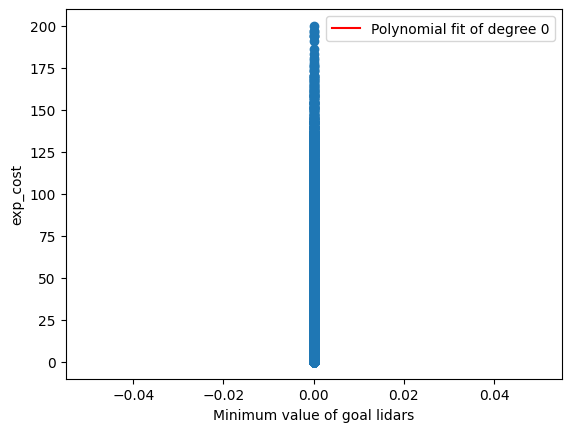

In [25]:
goal_cols = [f"goal_lidar{i}" for i in range(16)]
min_value_plot(df[goal_cols], df["exp_cost"], polynomial_degree=0, x_name="goal lidars")

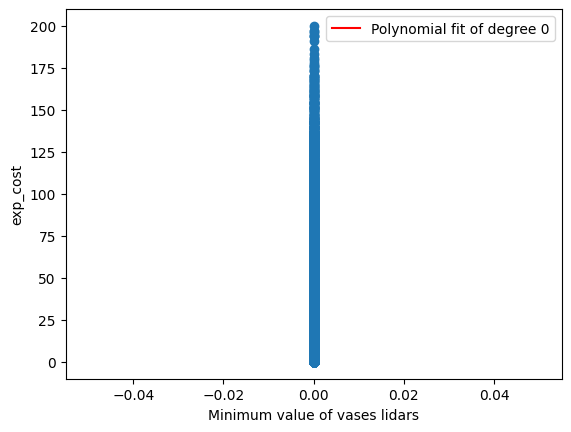

In [27]:
vases_cols = [f"vases_lidar{i}" for i in range(16)]
min_value_plot(df[vases_cols], df["exp_cost"], polynomial_degree=0, x_name="vases lidars")

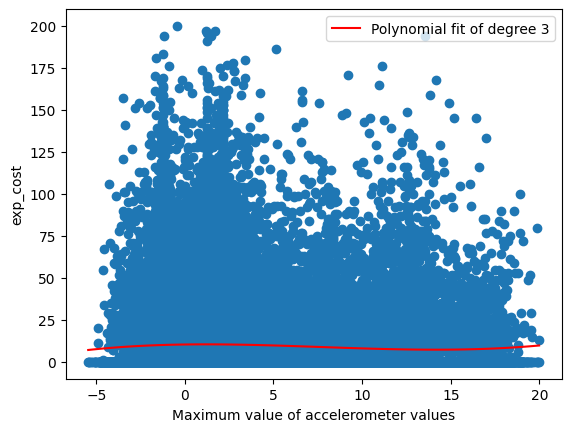

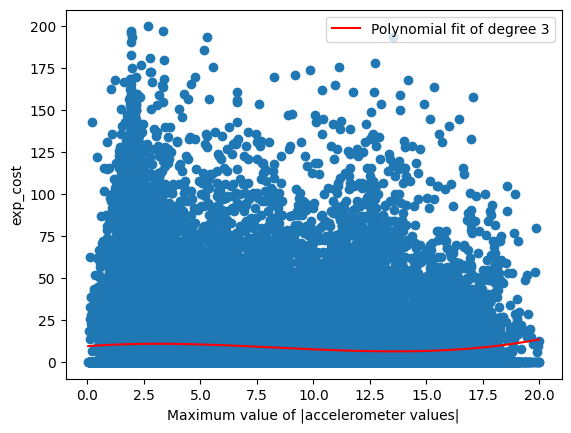

In [ ]:
accel_cols = [f"accelerometer{i}" for i in range(2)]
max_value_plot(df[accel_cols], df["exp_cost"], polynomial_degree=3, x_name="accelerometer values")
#min_value_plot(df[accel_cols], df["exp_cost"], polynomial_degree=3, x_name="accelerometer values")
abs_max_value_plot(df[accel_cols], df["exp_cost"], polynomial_degree=3, x_name="accelerometer values")

Plotting velocity against expected cost, but only for samples where agents moves to a target.

In [41]:
# lidar directions (lidars are uniformely arranged around the agent)
import numpy as np

num_lidars = 16
angles = np.linspace(0, 2 * np.pi, num=num_lidars, endpoint=False)
angles

array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633,
       1.96349541, 2.35619449, 2.74889357, 3.14159265, 3.53429174,
       3.92699082, 4.3196899 , 4.71238898, 5.10508806, 5.49778714,
       5.89048623])

In [42]:
# [x,y] velocity direction corresponding to lidars
directions = np.array([[np.cos(theta), np.sin(theta)] for theta in angles])
directions

array([[ 1.00000000e+00,  0.00000000e+00],
       [ 9.23879533e-01,  3.82683432e-01],
       [ 7.07106781e-01,  7.07106781e-01],
       [ 3.82683432e-01,  9.23879533e-01],
       [ 6.12323400e-17,  1.00000000e+00],
       [-3.82683432e-01,  9.23879533e-01],
       [-7.07106781e-01,  7.07106781e-01],
       [-9.23879533e-01,  3.82683432e-01],
       [-1.00000000e+00,  1.22464680e-16],
       [-9.23879533e-01, -3.82683432e-01],
       [-7.07106781e-01, -7.07106781e-01],
       [-3.82683432e-01, -9.23879533e-01],
       [-1.83697020e-16, -1.00000000e+00],
       [ 3.82683432e-01, -9.23879533e-01],
       [ 7.07106781e-01, -7.07106781e-01],
       [ 9.23879533e-01, -3.82683432e-01]])

In [43]:
hazard_cols = [f"hazards_lidar{i}" for i in range(16)]
aligned_sample_indices = []
for index, row in df.iterrows():
    closest_direction = np.argmax(row[hazard_cols])
    velocity_angle = np.dot(row[["velocimeter0", "velocimeter1"]], directions[closest_direction])
    if velocity_angle > 0.5: 
        aligned_sample_indices.append(index)
aligned_sample_indices = np.array(aligned_sample_indices)
aligned_sample_indices.shape

(21303,)

In [44]:
df_aligned = df.iloc[aligned_sample_indices]
df_aligned.head()

,accelerometer0,accelerometer1,accelerometer2,velocimeter0,velocimeter1,velocimeter2,gyro0,gyro1,gyro2,magnetometer0,magnetometer1,magnetometer2,goal_lidar0,goal_lidar1,goal_lidar2,goal_lidar3,goal_lidar4,goal_lidar5,goal_lidar6,goal_lidar7,goal_lidar8,goal_lidar9,goal_lidar10,goal_lidar11,goal_lidar12,goal_lidar13,goal_lidar14,goal_lidar15,hazards_lidar0,hazards_lidar1,hazards_lidar2,hazards_lidar3,hazards_lidar4,hazards_lidar5,hazards_lidar6,hazards_lidar7,hazards_lidar8,hazards_lidar9,hazards_lidar10,hazards_lidar11,hazards_lidar12,hazards_lidar13,hazards_lidar14,hazards_lidar15,vases_lidar0,vases_lidar1,vases_lidar2,vases_lidar3,vases_lidar4,vases_lidar5,vases_lidar6,vases_lidar7,vases_lidar8,vases_lidar9,vases_lidar10,vases_lidar11,vases_lidar12,vases_lidar13,vases_lidar14,vases_lidar15,action0,action1,exp_cost
0,-0.769528,11.532802,9.81,-1.098218,0.577155,0.0,0.0,-0.0,0.499018,-0.470912,0.168053,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.137822,0.144294,0.006471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012901,0.151751,0.305451,0.267432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.00000,0.000000,0.0,-1.250184,0.044456,0.0
2,2.154360,1.397201,9.81,0.470486,-0.724769,0.0,0.0,-0.0,2.972175,-0.166978,0.471294,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.194801,0.311719,0.116917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.547659,0.610956,0.548868,0.506628,0.374890,0.311188,0.011197,0.589502,0.679319,0.089817,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.196361,0.729051,0.53269,0.0,0.000000,0.00000,0.000000,0.0,1.017968,1.850806,0.0
10,-1.488008,11.061726,9.81,-0.726623,-0.702382,0.0,0.0,0.0,-0.357840,-0.470526,-0.169130,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.276880,0.477273,0.200393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084363,0.741025,0.656662,0.000000,0.322675,0.894011,0.848646,0.156256,0.856339,0.767148,0.697825,0.241604,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.197744,0.232387,0.034643,0.00000,0.0,0.000000,0.00000,0.000000,0.0,-2.868953,-1.851970,24.0
11,-1.946535,-1.060021,9.81,-0.398715,0.549789,0.0,0.0,0.0,3.021068,0.165425,0.471842,0.0,0.385231,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.324656,0.709886,0.250012,0.000000,0.000000,0.000000,0.466532,0.806792,0.340259,0.000000,0.000000,0.000000,0.242263,0.393700,0.485881,0.598521,0.651702,0.521532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.179007,0.50426,0.325253,0.0,-0.203716,1.422677,0.0
12,-1.845874,5.100086,9.81,-0.503610,-0.645759,0.0,0.0,0.0,-1.964806,-0.496780,-0.056657,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.249282,0.435365,0.186083,0.000000,0.183096,0.729903,0.546808,0.000000,0.000000,0.363050,0.768717,0.536519,0.580541,0.759454,0.867680,0.909937,0.129575,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.168657,0.689680,0.521023,0.00000,0.0,0.000000,0.00000,0.000000,0.0,-1.432893,-0.472224,55.0


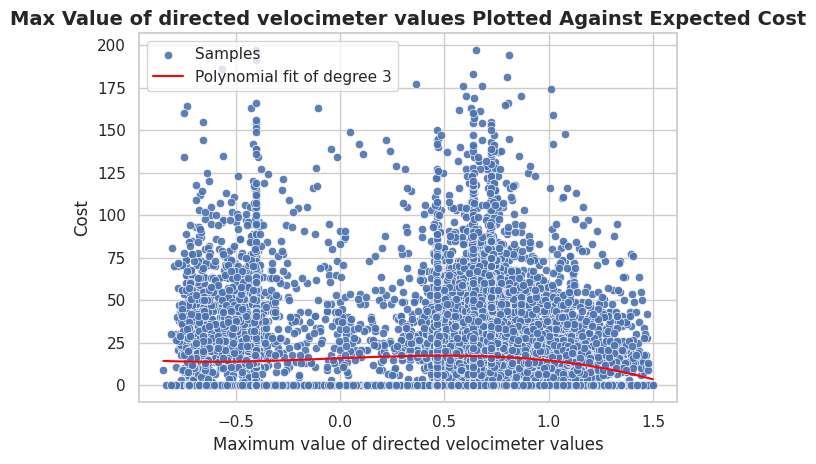

In [45]:
velocimeter_cols = [f"velocimeter{i}" for i in range(2)]
max_value_plot(df_aligned[velocimeter_cols], df_aligned["exp_cost"], polynomial_degree=3, x_name="directed velocimeter values")

In [9]:
def velocity_direction_plot(x_velo, y_velo, labels, polynomial_degree):
    velo_value = np.hypot(x_velo, y_velo) # gives the real velocity in the xy plane
    plt.scatter(velo_value, labels)

    coeffs = np.polyfit(velo_value, labels, deg=polynomial_degree)
    reg_line = np.poly1d(coeffs)
    x_line = np.linspace(velo_value.min(), velo_value.max(), 100)
    y_line = reg_line(x_line)

    plt.plot(x_line, y_line, color='red', label=f'Polynomial fit of degree {polynomial_degree}')
             
    plt.xlabel(f"Velocity")
    plt.ylabel("exp_cost")
    plt.legend()
    plt.show()

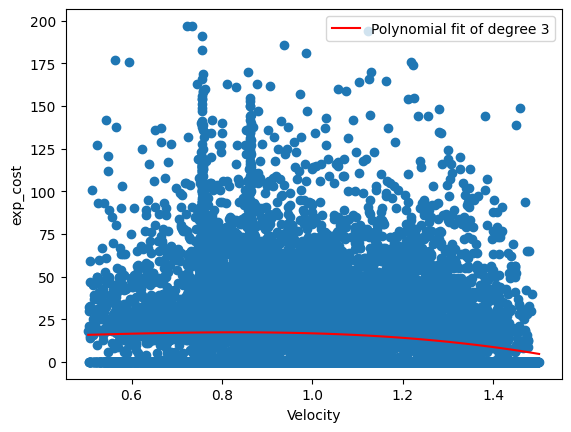

In [10]:
velocity_direction_plot(df_aligned["velocimeter0"], df_aligned["velocimeter1"], df_aligned["exp_cost"], polynomial_degree=3,)